In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [2]:
import sys
import os

# Caminho da pasta 'utils', uma pasta acima do notebook
utils_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'utils'))

# Adiciona ao sys.path se ainda não estiver
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Importa o módulo
import funcoes_avaliacao as funcoes_avaliacao


In [3]:
# Carregar e preparar dados
df_processed = pd.read_csv('C:/Users/Marcelo Almeida/Documents/TRABALHO DE CONCLUSÃO DE CURSO/projeto-tcc/data/processed/eng_features/aneel_processed_holdout_eng_feat.csv', encoding='utf-8-sig')
#df_processed = df_processed[['distribuidora_codificado','duracao_fila','duracao_atendimento','operacao_codificado','skill_codificado','hora','flag_pesquisa','resposta_1','resposta_2','resposta_3','rechamou_30min','media_rechamada_agente','media_rechamada_cliente']]
df_processed = df_processed[['distribuidora_codificado','duracao_fila','duracao_atendimento','operacao_codificado','short_call_30s','skill_codificado','hora','flag_pesquisa','resposta_1','resposta_2','resposta_3','rechamou_30min','media_rechamada_agente','media_rechamada_cliente', 'media_tempo_entre_chamadas','periodo','dia_semana_num','dia_de_semana','finalizacao_codificado']]

# Separar X e y (assumindo que a coluna do target chama "target")
X = df_processed.drop(columns=['rechamou_30min'])
y_true = df_processed['rechamou_30min']


In [4]:
df_processed['rechamou_30min'].value_counts(normalize=True)

rechamou_30min
0    0.844922
1    0.155078
Name: proportion, dtype: float64


🔍 XGBoost
{'accuracy': 0.8825687514136892, 'precision': 0.6176910140721696, 'recall': 0.6370495013999421, 'f1_score': 0.6272209236598072, 'auc': np.float64(0.8731385070649466), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93   1580095\n           1       0.62      0.64      0.63    290012\n\n    accuracy                           0.88   1870107\n   macro avg       0.78      0.78      0.78   1870107\nweighted avg       0.88      0.88      0.88   1870107\n'}

🔍 LightGBM
{'accuracy': 0.8830409169101019, 'precision': 0.620526294432722, 'recall': 0.6327565755899756, 'f1_score': 0.6265817598251784, 'auc': np.float64(0.8726184690532939), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93   1580095\n           1       0.62      0.63      0.63    290012\n\n    accuracy                           0.88   1870107\n   macro avg       0.78      0.

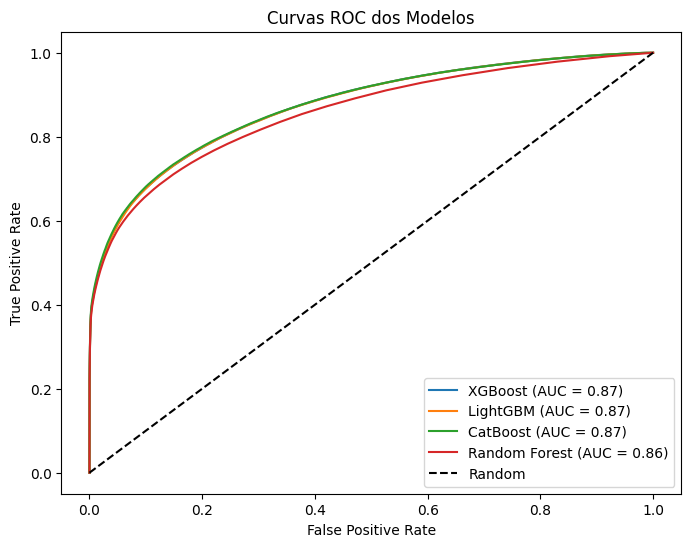

,Modelo,Accuracy,Precision,Recall,F1 Score,AUC
0,XGBoost,0.882569,0.617691,0.637050,0.627221,0.873139
1,LightGBM,0.883041,0.620526,0.632757,0.626582,0.872618
2,CatBoost,0.883198,0.619397,0.640201,0.629627,0.873979
3,Random Forest,0.903585,0.836270,0.470374,0.602091,0.857480


In [5]:

# Caminhos dos modelos
model_paths = {
    "XGBoost": os.path.join("../", "models", "XGBoost_eng_feat.pkl"),
    "LightGBM": os.path.join("../", "models", "LightGBM_eng_feat.pkl"),
    "CatBoost": os.path.join("../", "models", "CatBoost_eng_feat.pkl"),
    "Random Forest": os.path.join("../", "models", "Random Forest_eng_feat.pkl")
}

# Lista para salvar os resultados
resultados = []
modelos = []

for nome_modelo, path in model_paths.items():
    # Carregar modelo
    model = joblib.load(path)

    modelos.append((nome_modelo, model))
    
    # Fazer previsões
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Avaliar modelo (sua função personalizada deve retornar as métricas)
    metrics = funcoes_avaliacao.avaliar_modelo_pkl(nome_modelo, y_true, y_pred, y_proba)
    funcoes_avaliacao
    print(metrics)
   # Adicionar no dataframe
    resultados.append({
        "Modelo": nome_modelo,
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1_score"],
        "AUC": metrics["auc"]
    })
    
    # Plotar matriz de confusão
    #funcoes_avaliacao.plot_matriz_confusao(y_true, y_pred, nome_modelo)

# Converter em DataFrame para exibir em formato de tabela
df_resultados = pd.DataFrame(resultados)

plt.figure(figsize=(8,6))
for nome, modelo in modelos:
    y_prob = modelo.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)  # Já calculado na função
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC dos Modelos')
plt.legend()
plt.show()
display(df_resultados)


In [22]:
df_teste = pd.concat([X, pd.DataFrame({'y_true':y_true ,'y_pred': y_pred, 'y_proba': y_proba})], axis=1)
df_teste

,distribuidora_codificado,duracao_fila,duracao_atendimento,operacao_codificado,short_call_30s,skill_codificado,hora,flag_pesquisa,resposta_1,resposta_2,...,media_rechamada_agente,media_rechamada_cliente,media_tempo_entre_chamadas,periodo,dia_semana_num,dia_de_semana,finalizacao_codificado,y_true,y_pred,y_proba
0,13,2,231,1,0,12,0,0,0,0,...,0.283364,0.000000,NaN,3,5,1,5,0,0,0.10
1,9,2,392,1,0,43,0,1,1,0,...,0.521951,0.181818,17989.487255,3,5,1,6,0,0,0.16
2,9,0,225,1,0,12,0,1,5,0,...,0.566684,1.000000,5.883333,3,5,1,6,0,0,0.00
3,1,0,149,1,0,12,0,1,0,0,...,0.405517,1.000000,118947.800000,3,5,1,6,0,0,0.12
4,9,0,183,1,0,24,0,1,1,2,...,0.534320,0.000000,NaN,3,5,1,6,1,0,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870102,13,0,260,1,0,12,23,1,5,1,...,0.470536,0.000000,NaN,2,5,1,6,0,0,0.01
1870103,1,18,110,2,0,12,23,0,0,0,...,0.400350,1.000000,0.250000,2,5,1,5,0,0,0.20
1870104,9,0,87,1,0,12,23,1,0,0,...,0.368185,0.000000,195932.116667,2,5,1,6,0,0,0.40
1870105,5,1,46,2,0,24,23,0,0,0,...,0.651712,0.428571,54441.816667,2,5,1,5,0,1,0.72


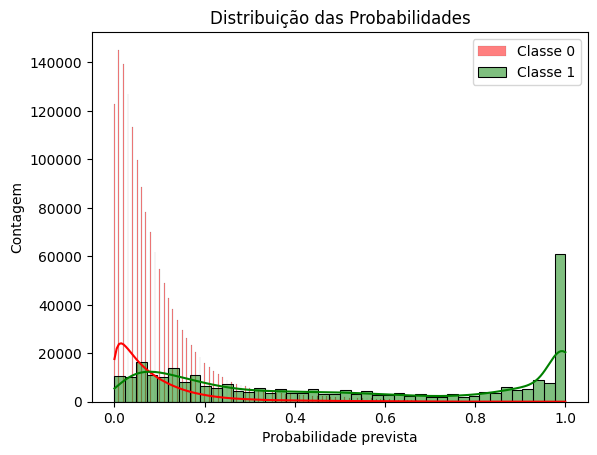

In [23]:
sns.histplot(df_teste[df_teste['y_true']==0]['y_proba'], color='red', label='Classe 0', kde=True)
sns.histplot(df_teste[df_teste['y_true']==1]['y_proba'], color='green', label='Classe 1', kde=True)
plt.xlabel('Probabilidade prevista')
plt.ylabel('Contagem')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.show()

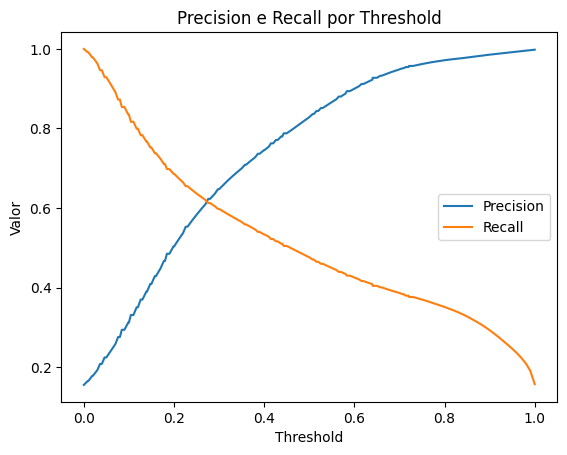

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_teste['y_true'], df_teste['y_proba'])
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Precision e Recall por Threshold')
plt.legend()
plt.show()

In [31]:
def avaliar_threshold(y_true, y_prob, threshold=0.5):
    y_pred_thresh = (y_prob >= threshold).astype(int)
    
    print(f"\n🔧 Threshold = {threshold:.2f}")
    print("Precision:", precision_score(y_true, y_pred_thresh))
    print("Recall:", recall_score(y_true, y_pred_thresh))
    print("F1 Score:", f1_score(y_true, y_pred_thresh))
    print("AUC:", roc_auc_score(y_true, y_prob))

    #plot_matriz_confusao(y_true, y_pred_thresh, f'Threshold {threshold:.2f}')

avaliar_threshold(X, y_proba, threshold=0.6)


🔧 Threshold = 0.60


c:\Users\Marcelo Almeida\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [26]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(modelo, X, y_true, cv=5, scoring='accuracy')
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Treino')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Teste')
plt.xlabel('Tamanho do treino')
plt.ylabel('Accuracy')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

NameError: name 'modelo' is not defined

In [21]:
df_teste[np.isclose(df_teste['media_rechamada_agente'], 0.566684)]

,distribuidora_codificado,duracao_fila,duracao_atendimento,operacao_codificado,short_call_30s,skill_codificado,hora,flag_pesquisa,resposta_1,resposta_2,resposta_3,media_rechamada_agente,media_rechamada_cliente,media_tempo_entre_chamadas,periodo,dia_semana_num,dia_de_semana,finalizacao_codificado,y_pred,y_proba
2,9,0,225,1,0,12,0,1,5,0,0,0.566684,1.000000,5.883333,3,5,1,6,0,0.00
26,9,0,151,1,0,12,0,0,0,0,0,0.566684,1.000000,NaN,3,5,1,5,0,0.26
32632,9,0,350,1,0,47,8,1,5,1,0,0.566686,0.500000,16453.466049,0,0,1,6,0,0.03
32987,9,0,384,1,0,12,8,0,0,0,0,0.566686,0.285714,21758.790741,0,0,1,5,0,0.11
64028,9,0,349,1,0,24,13,1,1,2,4,0.566688,0.137931,10066.508757,1,1,1,6,0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781073,17,0,127,2,0,24,11,1,5,1,0,0.566681,0.000000,NaN,0,2,1,6,0,0.01
1781179,13,0,285,2,0,24,11,1,0,0,0,0.566681,0.000000,188687.083333,0,2,1,6,0,0.06
1781440,5,0,658,2,0,24,11,1,5,0,0,0.566681,1.000000,15.791667,0,2,1,6,0,0.03
1781994,9,491,266,2,0,24,11,1,5,0,0,0.566681,1.000000,1.291667,0,2,1,6,0,0.02


In [ ]:
df_teste = pd.merge(X,y_pred,y_proba)
df_teste

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

In [9]:
plt.figure(figsize=(8,6))
for nome, modelo in resultados.items():
    y_prob = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = resultados[nome]['auc']  # Já calculado na função
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC dos Modelos')
plt.legend()
plt.show()
display(df_resultados)

AttributeError: 'list' object has no attribute 'items'

<Figure size 800x600 with 0 Axes>